# Experiments with Progressive GANs

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
X = drive.CreateFile({'id': file_id})
X = X.GetContentFile('m')

ApiRequestError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls -R

.:
adc.json  drive  progressive_growing_of_gans  sample_data  tfutil.py

./drive:
'My Drive'

'./drive/My Drive':
 2014142486.pdf
'AdmitCard (1).pdf'
'Advanced Robotics - Assignment 5.gdoc'
 Amit_Rege_Review1.gdoc
 Amit_Rege_Review2.gdoc
 Amit_Rege_Review3.gdoc
 Amit_Rege_Review4.gdoc
 Amit_Rege_Review5.gdoc
 Amit_Rege_Review6.gdoc
'Appel A.W. - Modern compiler implementation in ML-CUP (1999).pdf'
 August-2017.gdoc
 Bigdata.gslides
 BOM_Design_Homework1.gdoc
 BOM-GOI-1.pdf
 BST-BMT2013.pdf
'(Cambridge Series in Statistical and Probabilistic Mathematics) David Pollard - A User’s Guide to Measure Theoretic Probability-Cambridge University Press (2001).pdf'
 cat-v-dog-aug-model-1000.h5
 cat-v-dog-aug-model-1500.h5
 cat-v-dog-aug-model-2000.h5
 cat-v-dog-aug-model-2500.h5
 cat-v-dog-aug-model-3000.h5
 cat-v-dog-aug-model-3500.h5
 cat-v-dog-aug-model-500.h5
 cat-v-dog-model-1000.h5
 cat-v-dog-model-1500.h5
 cat-v-dog-model-2000.h5
 cat-v-dog-model-2500.h5
 cat-v-dog-model-3000.h5
 cat-v-dog

In [0]:
file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
X = drive.CreateFile({'id': file_id})
X = X.GetContentFile('m')

ApiRequestError: ignored

In [0]:
# Imports
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
from IPython.display import Image, display
import os

# Start TF session
tf.InteractiveSession()

In [0]:
# Saves model on remote PC
def get_model(name):
  if name == "lsun_bird":
    file_id = '1xce6ct41eKxTjyASRsKY8erSikFpVWG5'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bird.pkl')
  elif name == 'lsun_bedroom':
    file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bedroom.pkl')
  elif name == 'lsun_tower':
    file_id = '1z8gUcWvUxtAjKhCzr88BO62NFBLYQ32G'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bedroom.pkl')
  elif name == 'lsun_church':
    file_id = '1yGlooC5u4KuiOMzuJiA1W-MW4WB-wqnf'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_church.pkl')
  elif name == "celeb":
    file_id = '188K19ucknC6wg1R6jbuPEhTq9zoufOx4'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_celeb.pkl')

# Loads model
def load_model(name):
  get_model(name)
  with open('model_' + name + '.pkl', 'rb') as f:
    G, D, Gs = pickle.load(f)
  return G, D, Gs

In [0]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

fatal: destination path 'progressive_growing_of_gans' already exists and is not an empty directory.


In [0]:
# Required for pickle.load()
!cp progressive_growing_of_gans/tfutil.py .

In [0]:
with open('./drive/My Drive/karras2018iclr-lsun-bedroom-256x256.pkl', 'rb') as f:
  G, D, Gs = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Generate images (size: number of images to be generated)
# Keep partition_size < 100
def generate_images(G, D, Gs, size, partition_size):
  # Generate latent vectors.
  latents = np.random.randn(size, *Gs.input_shapes[0][1:])
  
  # Generate dummy labels (not used by the official networks).
  labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
  images = np.zeros((size, 3, 256, 256))
  
  # Generation is done in batches of 100 or less because Colab seems to crash with more images (lack of GPU memory)
  partitions = int(size/partition_size)
  for p in range(partitions):
    images[p*partition_size : (p+1)*partition_size] = Gs.run(latents[p*partition_size : (p+1)*partition_size], labels[p*partition_size : (p+1)*partition_size])
    
  # Convert images to PIL-compatible format.
  images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
  images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
  
  return images

In [0]:
def euclidean_dist(a, b):
  return np.sum(np.square(a-b))

def get_distances(arr):
  l = len(arr)
  dist = []
  
  for i in range(l):
    for j in range(l):
      if i < j:
        dist.append((euclidean_dist(arr[i], arr[j]), i, j))
    print(i)
  return dist

# Get top 20 closest pairs from generated images (returns a list of 20 tuples which are later used for display) 
def get_top_20(images):
  print("Calculating Pair wise Distances")
  dist = get_distances(images)
  print("Retrieving top 20 pairs")
  dist.sort(key = lambda tup:tup[0])
  return dist[:20]

In [0]:
# Display the top 20 pairs using the list generated from get_top_20()
def show_top_20(d, img):
  images = []
  
  i = 0
  for tup in d:
    images.append(img[tup[1]])
    images.append(img[tup[2]])
    i = i + 2
    
  # Save images as PNG.
  for idx in range(len(images)):
    PIL.Image.fromarray(images[idx], 'RGB').save('img%d.png' % idx)
    print(idx)
    
  listOfImageNames = ['img%d.png' % idx for idx in range(40)]
  
  i = 0
  for imageName in listOfImageNames:
    if i % 2 == 0:
      print("Pair")
    display(Image(filename=imageName))
    i = i + 1
    
  for imagename in listOfImageNames:
    os.remove(imagename)

In [0]:
# Note size should be a multiple of 50 (lower granularity is probably not worth it)
def bp_test(G, D, Gs, size):
  batches = int(size/1000)
  
  # Generate Images
  images = np.zeros((size, 256, 256, 3))
  for i in range(batches):
    images[i*1000 : (i+1)*1000] = generate_images(G, D, Gs, 1000, 100)
  images[batches*1000 : ] = generate_images(G, D, Gs, size - (batches*1000), 100)
  print("Generation Done")
    
  return images

In [0]:
#G, D, Gs = load_model('lsun_bedroom')
images = generate_images(G, D, Gs, 1000, 50)

In [0]:
images1 = generate_images(G, D, Gs, 1000, 50)

In [0]:
images2 = generate_images(G, D, Gs, 1000, 50)

In [0]:
images3 = generate_images(G, D, Gs, 1000, 50)

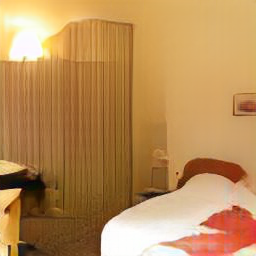

In [0]:
PIL.Image.fromarray(images3[6], 'RGB').save('img1.png')
display(Image(filename='img1.png'))
os.remove('img1.png')

In [0]:
# Get Top 20 pairs
d = get_top_20(np.concatenate((images, images1, images2, images3)))

Calculating Pair wise Distances
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
26

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Pair


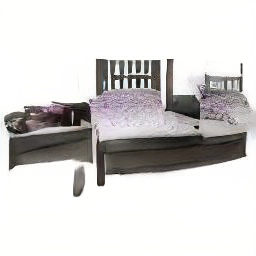

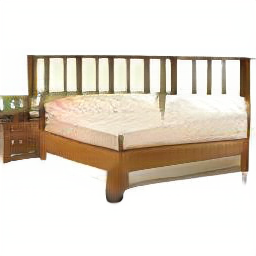

Pair


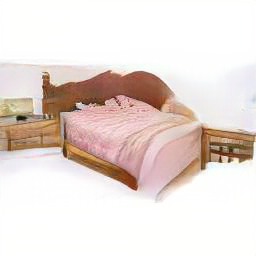

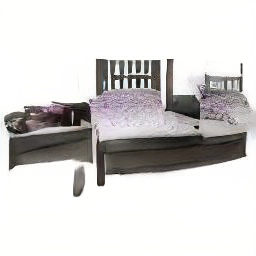

Pair


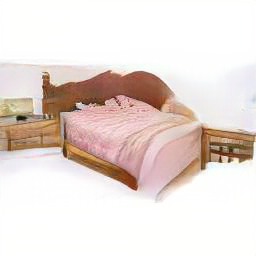

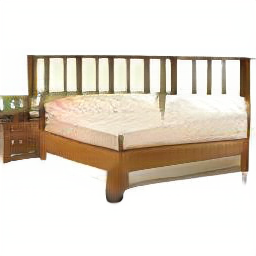

Pair


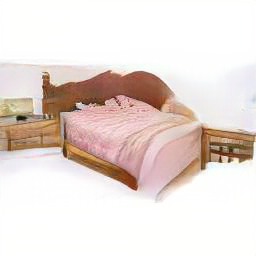

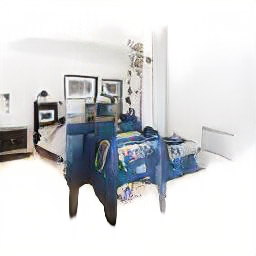

Pair


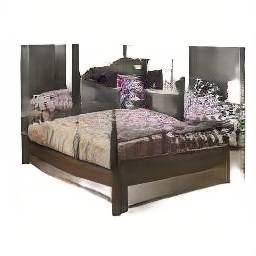

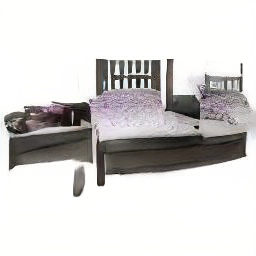

Pair


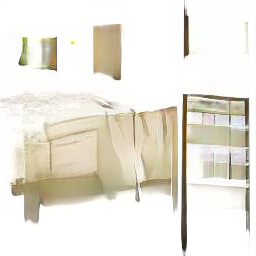

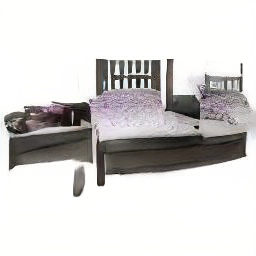

Pair


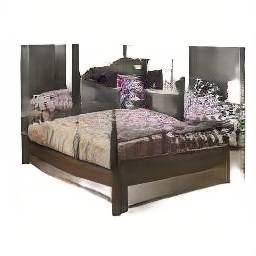

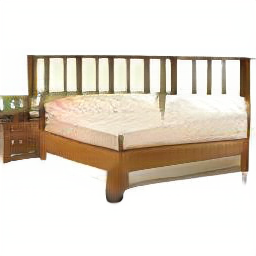

Pair


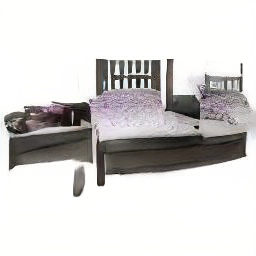

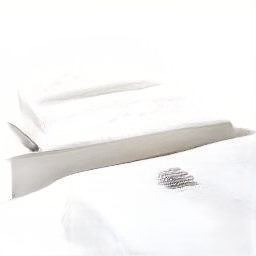

Pair


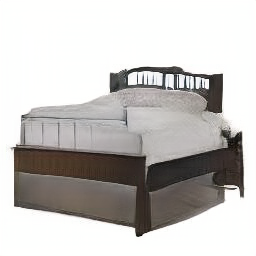

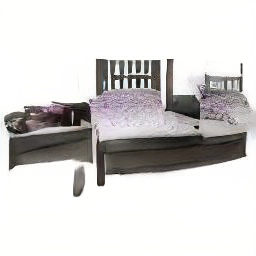

Pair


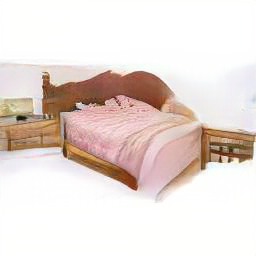

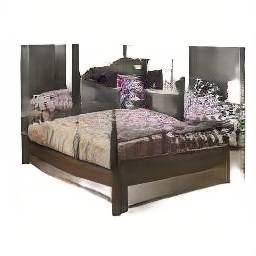

Pair


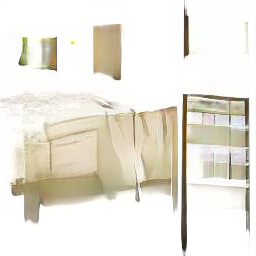

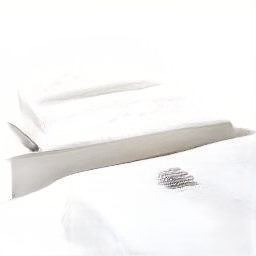

Pair


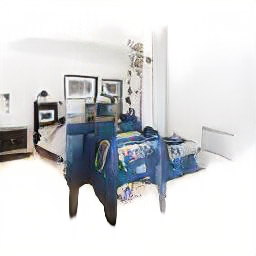

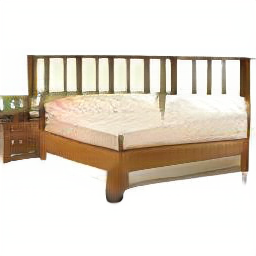

Pair


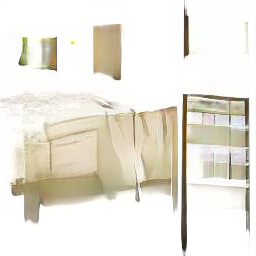

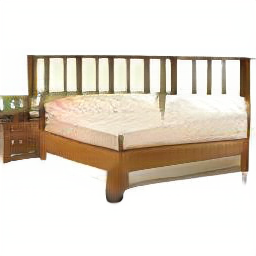

Pair


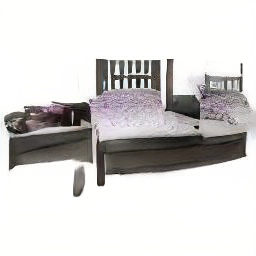

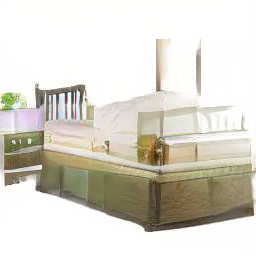

Pair


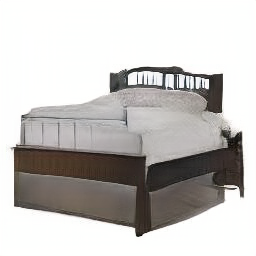

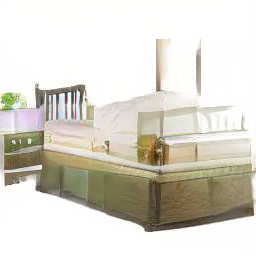

Pair


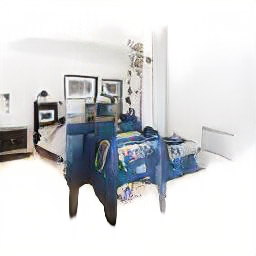

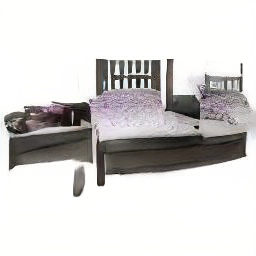

Pair


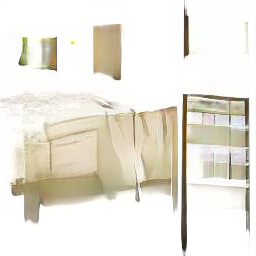

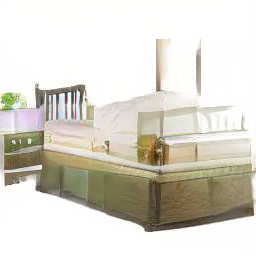

Pair


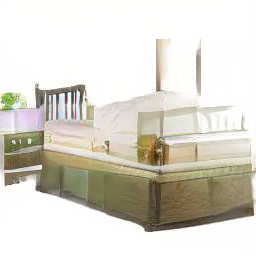

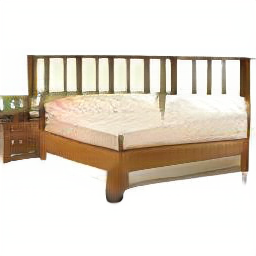

Pair


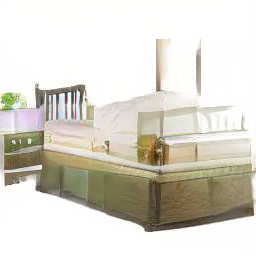

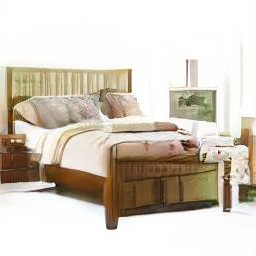

Pair


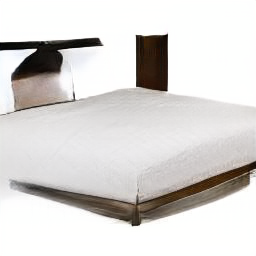

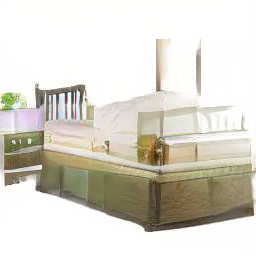

In [0]:
show_top_20(d, np.concatenate((images, images1, images2, images3)))

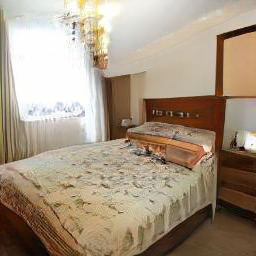

In [0]:
# Generate latent vectors.
size = 200
latents = np.random.randn(size, *Gs.input_shapes[0][1:])
  
# Generate dummy labels (not used by the official networks).
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
images = np.zeros((size, 3, 256, 256))
  
partitions = int(size/50)
for p in range(partitions):
  images[p*50 : (p+1)*50] = Gs.run(latents[p*50 : (p+1)*50], labels[p*50 : (p+1)*50])
    
  # Convert images to PIL-compatible format.
images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
  
PIL.Image.fromarray(images[6], 'RGB').save('img1.png')
display(Image(filename='img1.png'))
os.remove('img1.png')

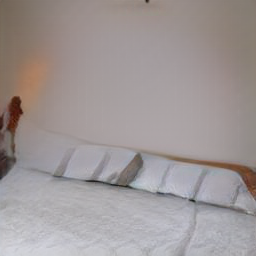

In [0]:
im = generate_images(G, D, Gs, 2000, 50)
PIL.Image.fromarray(im[5], 'RGB').save('img1.png')
display(Image(filename='img1.png'))
os.remove('img1.png')

40
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Pair


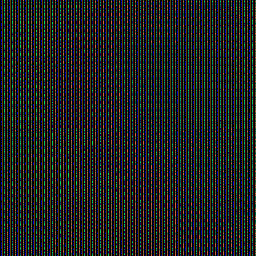

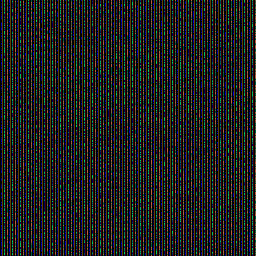

Pair


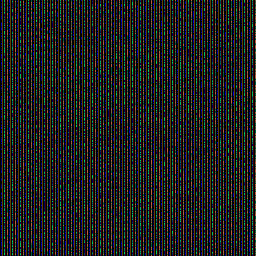

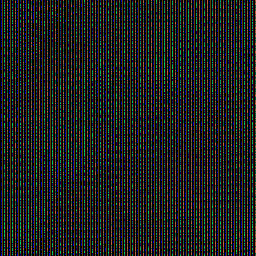

Pair


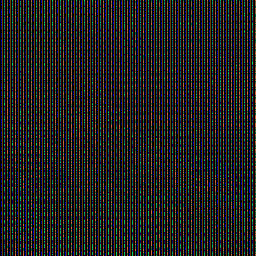

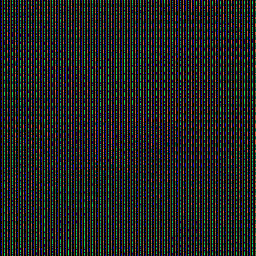

Pair


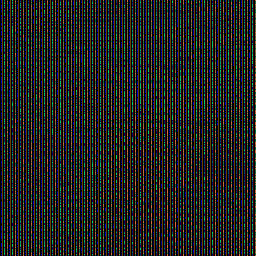

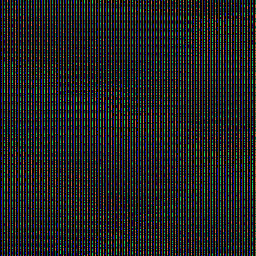

Pair


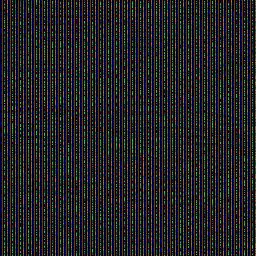

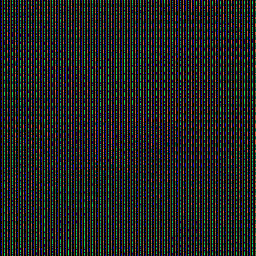

Pair


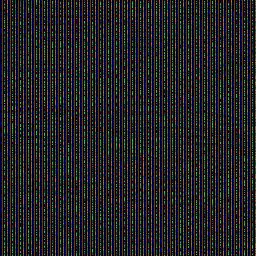

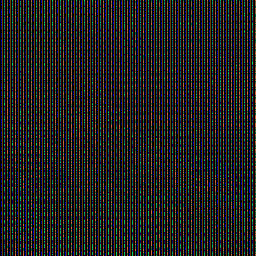

Pair


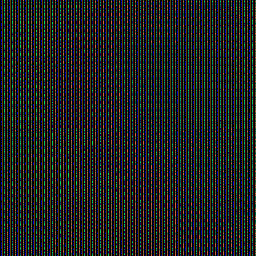

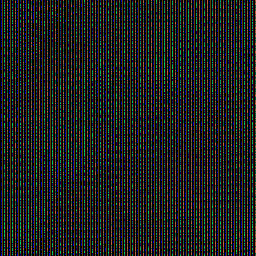

Pair


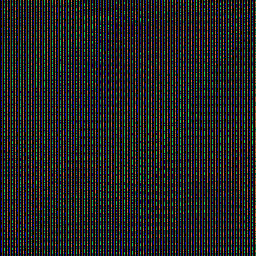

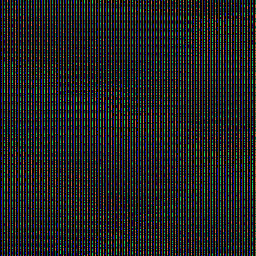

Pair


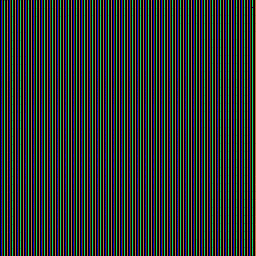

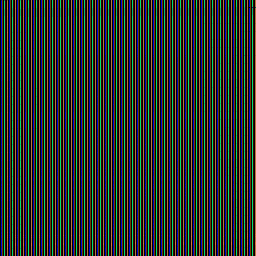

Pair


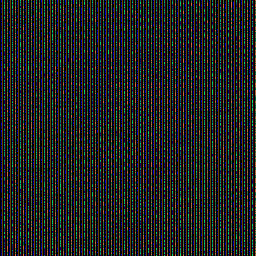

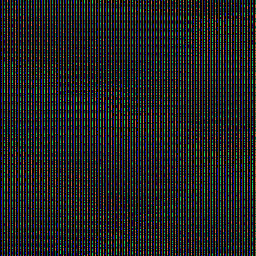

Pair


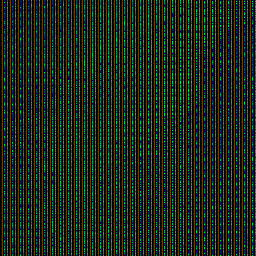

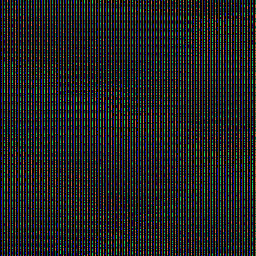

Pair


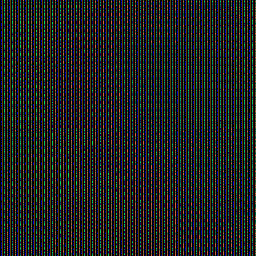

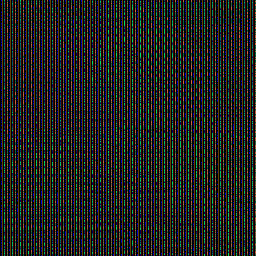

Pair


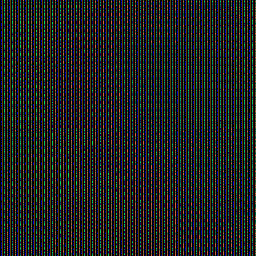

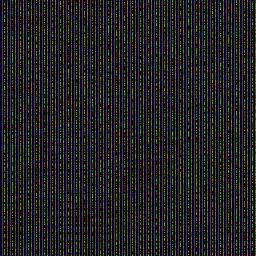

Pair


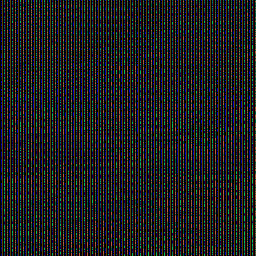

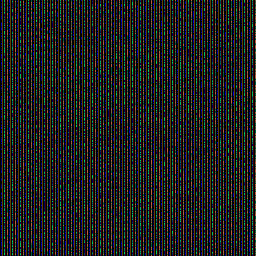

Pair


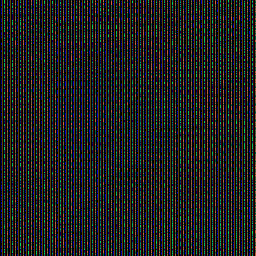

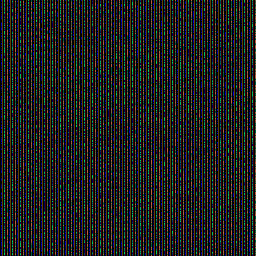

Pair


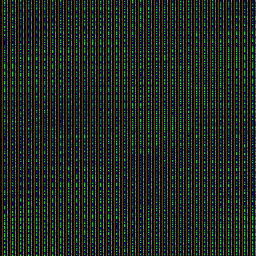

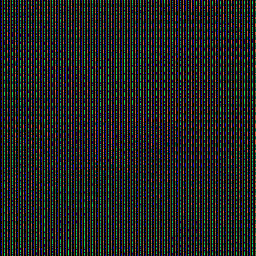

Pair


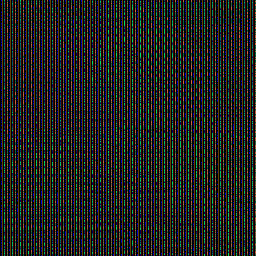

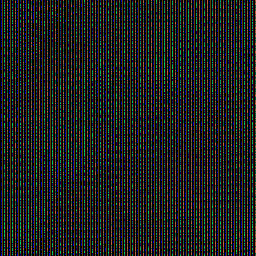

Pair


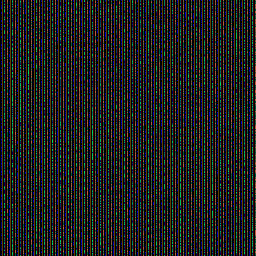

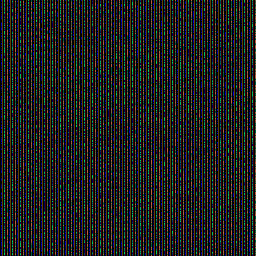

Pair


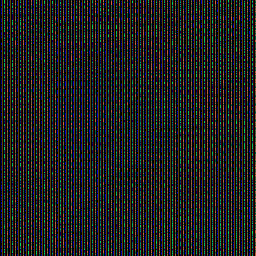

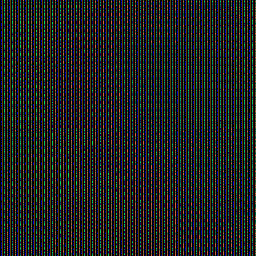

Pair


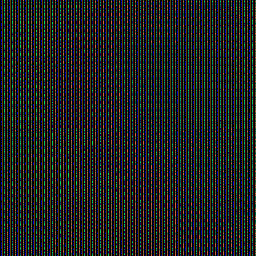

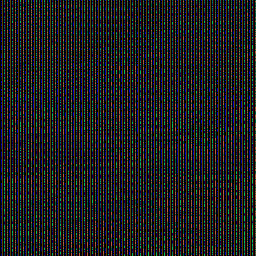

In [0]:
# Display Top 20 image pairs
show_top_20(d, images)

Generation Done


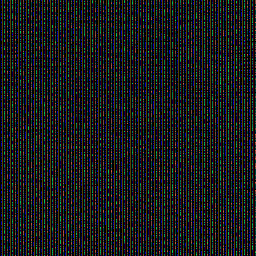

In [0]:
i = bp_test(G, D, Gs, 100)
PIL.Image.fromarray(i[5], 'RGB').save('img1.png')
display(Image(filename='img1.png'))
os.remove('img1.png')

In [0]:
dist = get_top_20(i)

Calculating Pair wise Distances
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Retrieving top 20 pairs


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Pair


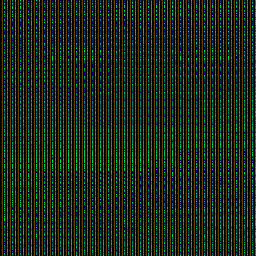

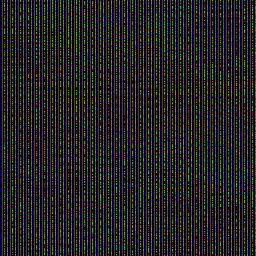

Pair


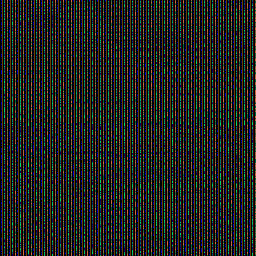

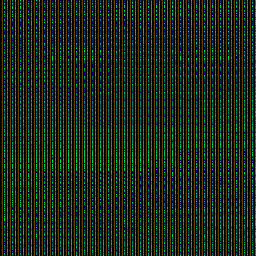

Pair


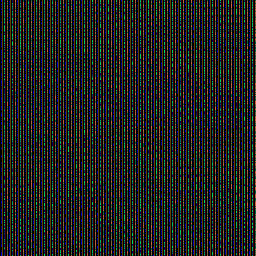

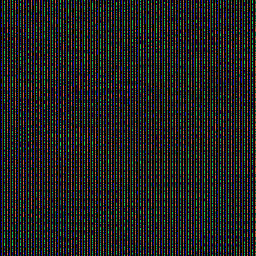

Pair


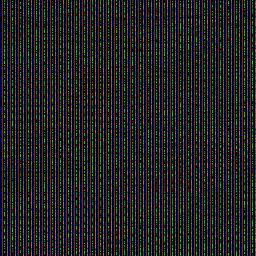

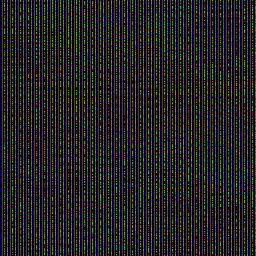

Pair


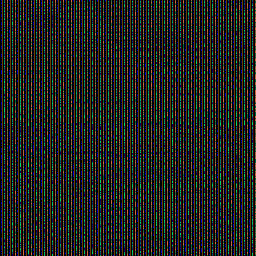

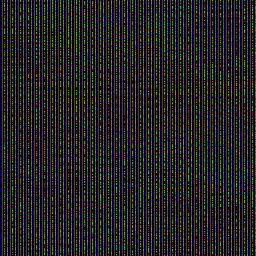

Pair


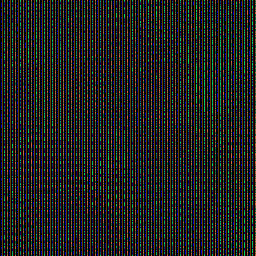

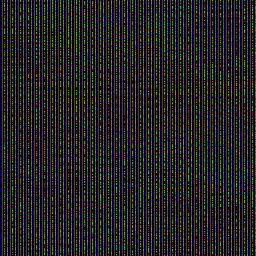

Pair


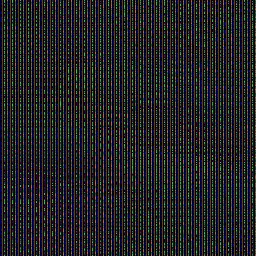

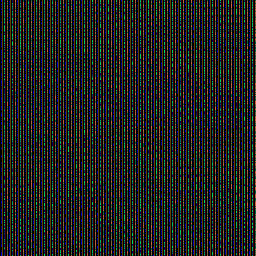

Pair


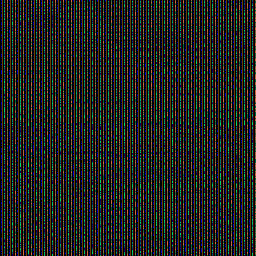

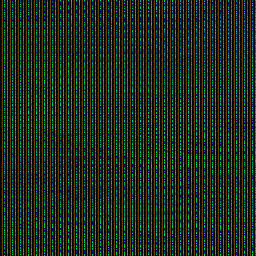

Pair


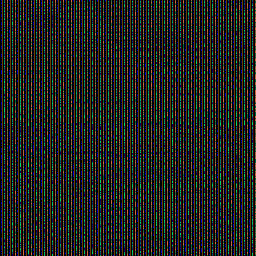

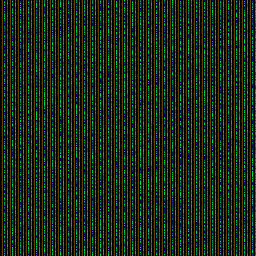

Pair


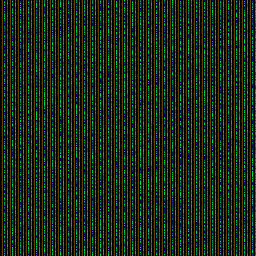

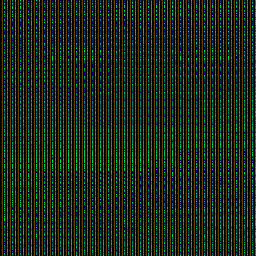

Pair


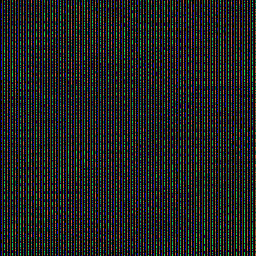

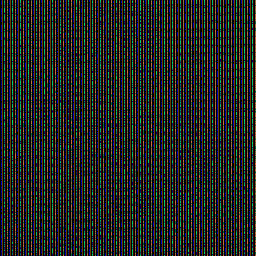

Pair


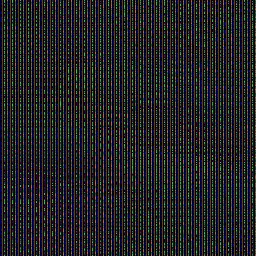

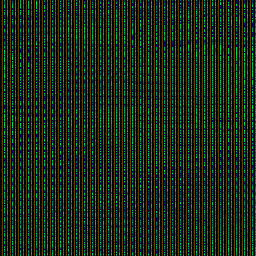

Pair


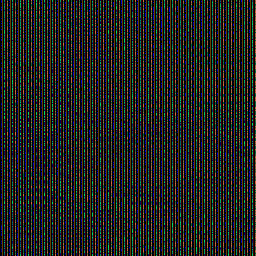

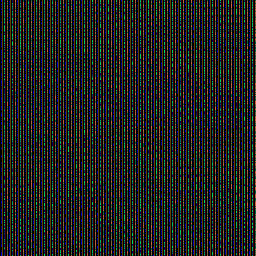

Pair


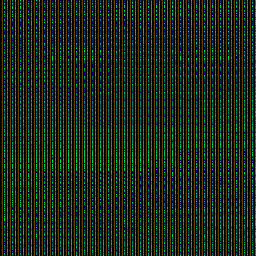

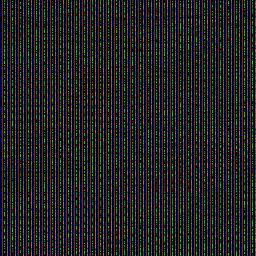

Pair


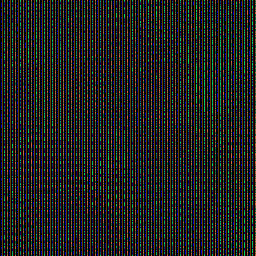

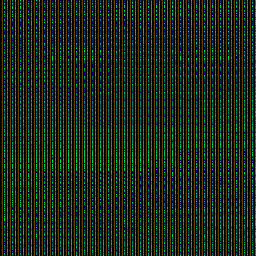

Pair


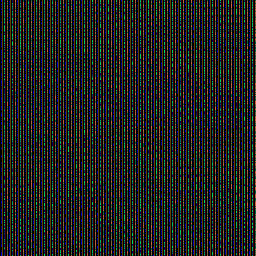

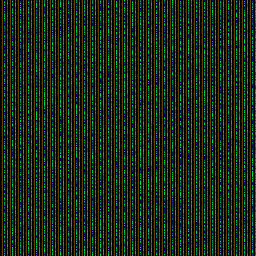

Pair


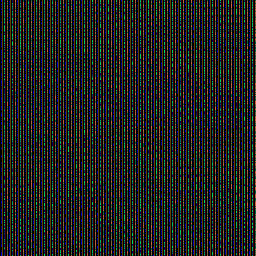

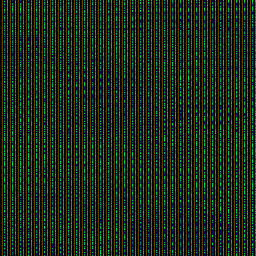

Pair


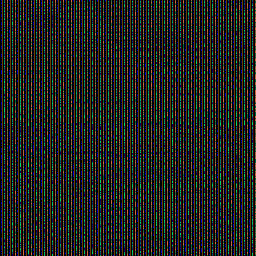

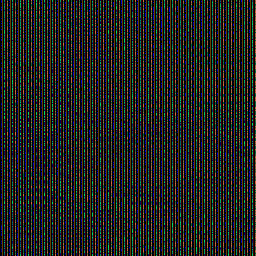

Pair


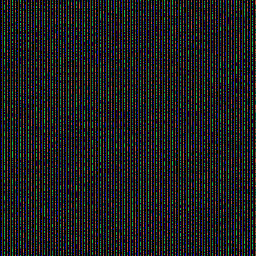

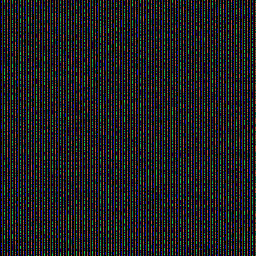

Pair


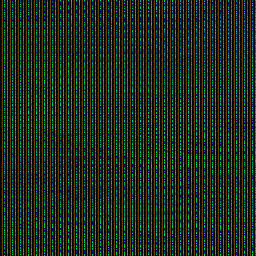

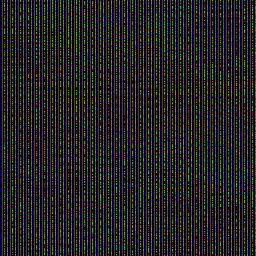

In [0]:
show_top_20(dist, i)

In [0]:
import matplotlib.pyplot as plt

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray(), interpolation='nearest')
        #axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    
def create_image_dict(dist, images):
  image_dict = {}
  i = 0
  for d in dist:
    image_dict['img%d'%i] = images[d[1]]
    i = i+1
    image_dict['img%d'%i] = images[d[2]]
    i = i+1
  return image_dict

In [0]:
def display_top_20(dist, images):
  d = create_image_dict(dist, images)
  plot_figures(d, nrows = 20, ncols = 2)

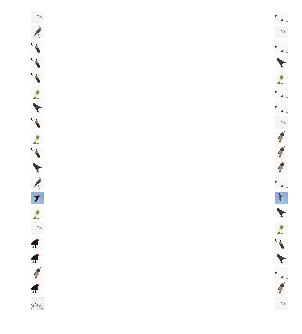

In [0]:
display_top_20(d, images)

In [0]:
!ls

adc.json  progressive_growing_of_gans  sample_data  tfutil.py


# Image gen


In [0]:
from PIL import Image as I, ImageDraw

In [0]:
image = I.new('RGB', (128, 128))
image.save("image.png", "PNG")

r = 50
x = 50
y = 50
image = I.open("image.png")
draw = ImageDraw.Draw(image)
draw.ellipse((x-r, y-r, x+r, y+r), fill='red')

draw.text((x,y),"Amit", fill = "blue")
image.save('image.png')

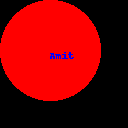